# PARTICLE SWARM OPTIMIZATION

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sympy as sym
from sympy.solvers import solve, solveset
import sympy
import random
import mpmath
from celluloid import Camera

In [2]:
def func(*args):
    return 0.02*args[0]**4 - 0.6*args[0]**3 - 35*args[0]**2 + 50*args[0]

## Particle class

In [3]:
class Particle:
    def __init__(self, velocity, position, weights):
        self.velocity = velocity
        self.position = position
        self.loss = np.inf
        self.best_position = position
        self.weights = weights
    
    def move(self):
        """
        Move particle to a new position
        """
        new_position = self.position + self.velocity
        return new_position
    
    def Print_info(self):
        """
        print particle information
        """
        print('Velocity: {}'.format(self.velocity))
        print('Position: {}'.format(self.position))
    
    def update_velocity(self, best_particle):
        """
        Update velocity of particle
        """
        global_best = self.weights[0] * random.random() * (best_particle.position - self.position)
        known_best = self.weights[1] * random.random() * (self.best_position - self.position)
        
        new_velocity = self.weights[2] * self.velocity + global_best + known_best
        return new_velocity

## Particle Swarm class

In [12]:
class ParticleSwarm:
    """
    Particle swarm Class
    """
    def __init__(self, function, variables, iterations, 
                 particles=10, track_movement=False, particle_weights = (2, 1, 0.5)):
        
        def create_particles(num_particles):
            """
            Helper function for creating particles
            """
            particles = []
            for i in range(num_particles):
                velocity = random.random()
                position = random.choice([-1,1]) * 500 * random.random()
                weights = particle_weights
                particles.append(Particle(velocity, position, weights))
            return particles
        
        self.function = function
        self.iterations = iterations
        self.variables = variables
        self.particles = create_particles(particles)
        
        self.optimal_value = self.opt_val_func()
        self.track_movement = track_movement 
        
    
    def get_derivative(self):
        """
        Compute Derivate of 1-variable function
        """
        variables = sym.symbols(*self.variables)
        func_out = self.function(variables)
        return sym.diff(func_out)
    
    def opt_val_func(self):
        """
        Compute roots of Function
        """
        variables = sym.symbols(*self.variables)
        return solveset(self.get_derivative(), variables)
    
    def loss_particle(self, position):
        """
        Compute function value for a position
        """
        loss = self.function(position)
        return loss
    
    def get_best_particle(self):
        """
        Finding the best positioned particle
        """
        best_loss = np.inf
        best_part = None
        for particle in self.particles:
            particle.loss = self.loss_particle(particle.position)
            if particle.loss < best_loss:
                best_part = particle
                best_loss = best_part.loss
        return best_part
            
    
    def optimize_swarm(self):
        """
        Optimize swarm
        """
        best_part = self.get_best_particle()
        best_loss = best_part.loss
        
        if self.track_movement:
            positions_list = np.array([])
            velocity_list = np.array([])
        
        for i in range(self.iterations):
            current_best = best_loss
            for particle in self.particles:
                if self.track_movement:
                    positions_list = np.append(positions_list, particle.position)
                    velocity_list = np.append(velocity_list, particle.velocity)
                    
                particle.velocity = particle.update_velocity(best_part)
                particle.position = particle.move()
                particle.loss = self.loss_particle(particle.position)
                
                if particle.loss  < self.loss_particle(particle.best_position):
                    particle.best_position = particle.position

                if self.loss_particle(particle.best_position) < best_loss:
                    best_part = particle
                    best_loss = particle.loss
                    
        if self.track_movement:
            positions_list = np.reshape(positions_list, (i+1, -1))
            velocity_list = np.reshape(velocity_list, (i+1, -1))
            return dict({'positions': positions_list, 'velocities':velocity_list})
        else:
            return
    
    def generate_gif(self):
        """
        Generate GIF of swarm optimization
        """
        roots = [root for root in self.optimal_value]
        roots_val = [self.function(root) for root in roots]
        derivative = self.get_derivative()
        
        x_list = []
        y_list = []
        for i in range(-100, 100):
            i = i
            x_list.append(i)
            y_list.append(self.function(i))
        
        camera = Camera(plt.figure())
        particles_dict = self.optimize_swarm()
        val_positions = np.apply_along_axis(self.function, 0, particles_dict['positions'])

        for i in range(self.iterations):
            function, = plt.plot(x_list, y_list, c='b')
            root_scat = plt.scatter(roots, roots_val, s=50, c='red')
            swarm = plt.scatter(particles_dict['positions'][i,:], val_positions[i,:], c='black')
            plt.legend([function, root_scat, swarm], 
                       [str(self.function(sym.symbols(*self.variables))), 'roots', 'particles'])

            plt.xlim(-60, 80)
            plt.ylim(min(y_list)*1.2, max(y_list)*0.1)
            plt.title('Particle Swarm Optimization \n Particle Weights: {}'.format(str(self.particles[0].weights)))

            camera.snap()
        anim = camera.animate(blit=True)
        anim.save('PSO2.gif')

## Generate GIF

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


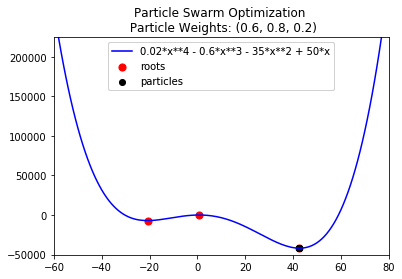

In [13]:
swarm = ParticleSwarm(func, 'x', 100, particles=50, track_movement=True, particle_weights=(0.6, 0.8, 0.2))
swarm.generate_gif()